# 支持向量机1

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

# To make this notebook's output stable across runs
np.random.seed(42)

# For accuracy_score, classification_report and confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TOPIC_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# For plotting MNIST digits in the last exercise
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")    

## 2. Support Vector Machines - Introduction

Support Vector Machines (SVMs) are powerful machine learning methods, able to form both linear and non-linear decision boundaries. They can be used for both classification and regression. In this tutorial we will learn how to implement linear and nonlinear SVMs for classification using <b>sklearn</b>. We will also explore the effect of the parameters on SVM's performance. 

## 3. Prepare and load the data

We will use the breast cancer datset as an example. SVM classifiers work better when the features are on the same scale, so we will normalise the data:

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Create the training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

# Normalise data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()#creating an object
scaler.fit(X_train)#calculate min and max value of the training data
X_train_norm = scaler.transform(X_train) #apply normalisation to the training set
X_test_norm = scaler.transform(X_test) #apply normalization to the test set

## 4. Create SVM classifiers

We wil use the SVC class to create linear and non-linear SVM classifiers. SVC stands for "Support Vector Classifier".

We start with creating a linear SVM. We need to set the kernel parametet to "linear"; the default is "rbf", corresponding to Radial-Basis Function (RBF) kernel, i.e. a non-linear SVM. We can see the other default parameters:

In [3]:
from sklearn.svm import SVC
lin_svm = SVC(kernel="linear")
lin_svm.fit(X_train_norm, y_train)

SVC(kernel='linear')

Testing the linear SVM on the test data:

In [4]:
y_pred = lin_svm.predict(X_test_norm)
print("Linear SVM - accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

Linear SVM - accuracy on test set: 0.979


Now let's create two other SVMs - nonlinear, with polynomial and RBF kernels respectively, and compare the results.

In [5]:
# SVM with polynomial kernel
poly_svm = SVC(kernel="poly", degree=2)#polynomial kernel with degree 2
poly_svm.fit(X_train_norm, y_train)
y_pred = poly_svm.predict(X_test_norm)
print("SVM with polynomial kernel - accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

# SVM with RBF kernel
rbf_svm = SVC(kernel="rbf", gamma="auto")
rbf_svm.fit(X_train_norm, y_train)
y_pred = rbf_svm.predict(X_test_norm)
print("SVM with RBF kernel - accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

SVM with polynomial kernel - accuracy on test set: 0.986
SVM with RBF kernel - accuracy on test set: 0.944


## 5. Tuning SVM parameters

SVM classifiers are very sensitive to the values of the parameters. To demonstrate this we will use a simpler dataset - the <b>moons</b> dataset. It contsins data from 2 classes described with 2 features; the data points form 2 half circles (moons). Let's generate and plot the data:

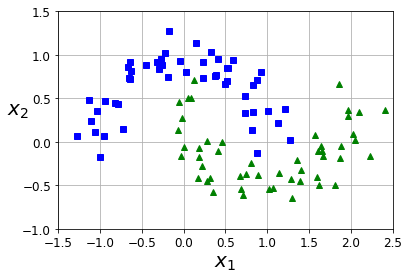

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Now let's run SVM with RBF kernel on the moons dataset, with different values of the gamma and C parameters (the most important parameters) and observe how the decision boundary changes.

The parameter C controlds the regularization while the parameter gamma controls the width of the Gaussian kernel - smaller gamma means larger width and vice versa.

Saving figure moons_rbf_svc_plot


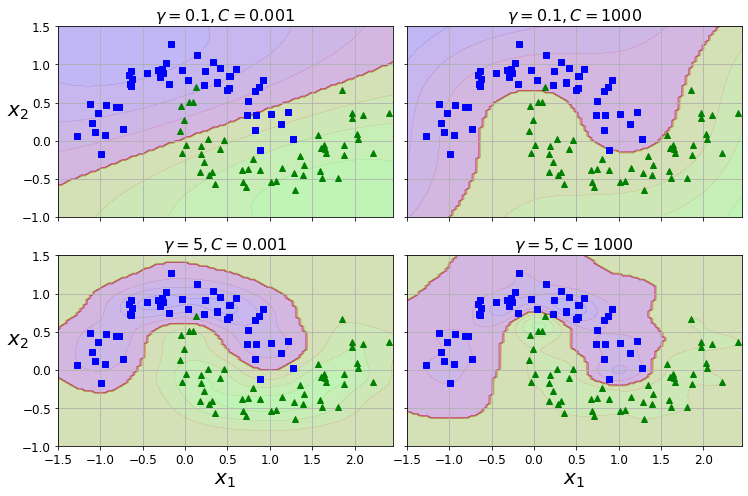

In [7]:
# Helper function for plotting the decision boundary
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

# Create SVM with different gamma and C values 
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

# Plot the datset and decision boundary
for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

Going from top to bottom, the value of <b>gamma</b> increases:
- a small <b>gamma</b> (top figures) means a large radius of the bell-shaped RBF curve, i.e. the instances have a large receptive field and influence. As a result, the decision boundary is smoother, almost a line in the top-left figure. 
- a big <b>gamma</b> (bottom figures) means a narrower bell-shape, i.e. each instance has a smaller receptive field and influence. As a result, the decision bountary is more irregular, wiggling around the individual instances.

Hence, <b>gamma</b> acts as a regularization parameter - if the SVM model is overfitting, <b>gamma</b> should be reduced; conversely, if it is underfitting - <b>gamma</b> should be increased.

Going from left to right, the value of <b>C</b> increases. Similarly to logistic regression and linear models:
- small <b>C</b> means a very restricted model, where each point has a small influence. We can see this in the top left figure - the decision boundary is almost a line and the misclassified points do not have any influence on it.
- big <b>C</b> means a less restrictive model and a bigger influence of all points. We can see how the decision boundary bends correctly to clasifify the previously misclassified points (compare the left top and left bottom figures).

Hence, a smaller <b>C</b> should be used if the model overfits and a larger if it underfits.

Tuning the SVM parameters is very important. It is necessary to experiment with different types of kernels and other parameters, e.g. using cross validation and grid search. 

Regarding the type of kernel - the rule of thumb is to try first a linear kernel. In addition to SVC(kernel="linear"), there is another option: using the class LinearSVC. LinearSVC is much faster that SVC(kernel="linear"), especially if the training set is large (has many features and many examples). Next, SVM with RBF kernel should be tried as it typically works well, and then other types of kernels.

## 6. Tasks: SVM

Task 1: Load the iris dataset. Create two SVM classifiers: linear and RBF, and evaluate their accuracy using a single training/test split. Do this for a chosen set of parameter values, e.g. the default.

Task 2: Consider the RBF SVM classifier. Use grid search with cross-validation to select a good combination of values for <b>C</b> and <b>gamma</b> from the following values: C = {0.001, 0.01, 0.1, 1, 10, 100} and gamma = {0.001, 0.01, 0.1, 1, 10, 100}. Show the accuracy on the test set.

## 7. Dimensionality Reduction using Principal Component Analysis

Principal Component Analysis (PCA) is a very popular method for dimensionality reduction. 

Let's apply PCA to the breast cancer data. It has 30 features. We can use PCA to find a lower-dimensional representation of this dataset that preserves the essential information. We will then apply a classifier, e.g. 1-nearest neighbor, on the original and reduced datasets and compare the results.

We have already loaded the breast cancer dataset and split it into training and test set - see Sec. 3 above. To apply PCA, we instantiate the PCA object, find the principle components by calling the <b>fit</b> method (applied to the training set only), and then project the training and test sets into the hyperpane defined by the first <b>n</b> principal components by calling the <b>transform</b> method. 

We have set the number of components to 2, so the dimensionality reduction is from 30 to 2 dimensions (features). Recall that principal components define a new coordinate system in which the first axis corresponds to the direction of the highest variance in data, the second axis is ortogonal to the first one and corresponds to the second highest variance in data, and so on. We can check that the dimensionality was reduced to 2 by printing the shape of the original and transformed data. 

In [8]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
# fit PCA model to the normalised breast cancer training data
pca = PCA(n_components=2).fit(X_train_norm)

# transform training and test data onto the first two principal components
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

print("Original shape of training data: {}".format(str(X_train_norm.shape)))
print("Reduced shape of training data: {}".format(str(X_train_pca.shape)))

Original shape of training data: (426, 30)
Reduced shape of training data: (426, 2)


Let's apply 1-nearest neighbor to the original (30-dimensional) and the reduced (2-dimensional) data. We can see that the accuracy is high in both cases and almost the same: 0.94 vs 0.92. Hence, PCA was able to find a two-dimensional representation where the two classes separate well (accuracy >90%) when using 1-nearest neighbor.

Although we didn't see an improvement in accuracy on this dataset, PCA is very useful for highly dimensional data and often results in improved accuracy.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_norm, y_train)
print("Original data - 1-nn accuracy: {:.2f}".format(knn.score(X_test_norm, y_test)))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Reduced data - 1-nn accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Original data - 1-nn accuracy: 0.94
Reduced data - 1-nn accuracy: 0.92


## 8. Choosing the right number of dimensions in PCA

In the example above we chose to reduce the dimemsnionality to 2. Instead of arbitrary choosing the number of dimensions for the dimensionality reduction, we can specify the percentage of variance that we would like to preserve. 

The variable <b>explained_variance_ratio_</b> shows the proportion of the dataset variance that lies along each ptincipal component. For our dataset: 52.75% of the dataset's variance lies along the first principal compoinent and 17.96% lies along the second principal component. This leaves 29.29% for the third and other principal componnets so they will be informative.  

In [10]:
pca.explained_variance_ratio_

array([0.527535  , 0.17964211])

We can specify the percentage of variance we want to preserve, which will determine how many principal components to use to preserve this variance:

In [11]:
pca=PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_norm)

print("Reduced shape of training data: {}".format(str(X_train_reduced.shape)))

Reduced shape of training data: (426, 9)


Hence, 9 principal components are required to preseve 95% of the variance on the breast cancer datset.

Another option is to plot the explained variance vs the number of dimensions and inspect the graph visually. There will usually be an elbow in the curve, where the explained variance stops growing fast and this will determine the number of dimensions to use. 

The following code shows how to plot the graph. The elbow is at 5-9 dimensions (determining this is subjective), so the graph suggest that if we chose 5-9 dimensions we would lose little explained variance.

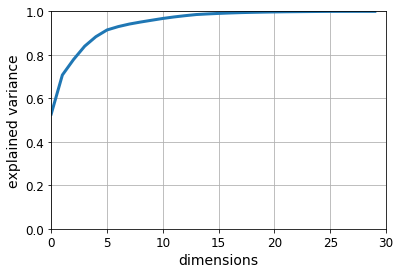

In [12]:
# Perform PCA without reducing dimensionality
pca = PCA()
pca.fit(X_train_norm)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 30, 0, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

## 9. Task: PCA for compression

PCA can also be applied for compression. We can demonstarte this on the MNIST digits dataset which contains 784 features.

Task 3: 

1) Apply PCA to the MNIST dataset to reduce the number of features preserving 95% of the variance. How many features are needed? Plot the graph showing the explained variance vs the number of dimensions. Use the elbow method to select the number of features.

2) Decompress the reduced dataset back to 784 features using the <b>inverse_transform</b> method. Plot some digits from the the original dataset and their corresponding compressed version and observe the difference. Use the <b>plot_digits</b> function to plot the digits. 

Solution:

To help you get started, we have loaded the MNIST dataset. The next step is to split it into training and test set and apply PCA.

In [13]:
# load the MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

## Summary

In [14]:
lin_svm = SVC(kernel="linear")
lin_svm.fit(X_train_norm, y_train)
y_pred = lin_svm.predict(X_test_norm)
print("Linear SVM - accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

rbf_svm = SVC(kernel="rbf", gamma="auto")
rbf_svm.fit(X_train_norm, y_train)
y_pred = rbf_svm.predict(X_test_norm)
print("SVM with RBF kernel - accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

pca=PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_norm)
X_test_reduced = pca.transform(X_test_norm)
print("Original shape of training data: {}".format(str(X_train_norm.shape)))
print("Reduced shape of training data: {}".format(str(X_train_reduced.shape)))    

Linear SVM - accuracy on test set: 0.979
SVM with RBF kernel - accuracy on test set: 0.944
Original shape of training data: (426, 30)
Reduced shape of training data: (426, 9)


## Acknowledgements

This tutorial is based on:

Aurelien Geron (2022). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

Andreas C. Mueller and Sarah Guido (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists, O'Reilly.
